In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from skimage.metrics import structural_similarity as ssim

device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Define the Encoder Network
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.conv4 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.conv5 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU(True)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        return x

# Define the Decoder Network
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.deconv1 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.deconv5 = nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU(True)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        x = self.relu(self.deconv4(x))
        x = self.tanh(self.deconv5(x))
        return x

# Instantiate the networks and move them to the appropriate device
encoder = Encoder().to(device)
decoder = Decoder().to(device)

# Freeze the encoder parameters
for param in encoder.parameters():
    param.requires_grad = False

# Define the loss function and optimizer
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(decoder.parameters(), lr=0.0002)

# Data loading and transformations
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Using CIFAR-10 dataset for demonstration
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
        # Move data to the appropriate device
        data = data.to(device)

        # Encode and then Decode
        with torch.no_grad():
            latent_rep = encoder(data)
        output = decoder(latent_rep)

        # Calculate loss
        loss = criterion(output, data)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("Training finished.")


100%|██████████| 170498071/170498071 [00:12<00:00, 13994354.03it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Epoch [1/10], Step [0/782], Loss: 0.2385
Epoch [1/10], Step [100/782], Loss: 0.1547
Epoch [1/10], Step [200/782], Loss: 0.0978
Epoch [1/10], Step [300/782], Loss: 0.0749
Epoch [1/10], Step [400/782], Loss: 0.0732
Epoch [1/10], Step [500/782], Loss: 0.0653
Epoch [1/10], Step [600/782], Loss: 0.0733
Epoch [1/10], Step [700/782], Loss: 0.0584
Epoch [2/10], Step [0/782], Loss: 0.0651
Epoch [2/10], Step [100/782], Loss: 0.0583
Epoch [2/10], Step [200/782], Loss: 0.0536
Epoch [2/10], Step [300/782], Loss: 0.0562
Epoch [2/10], Step [400/782], Loss: 0.0526
Epoch [2/10], Step [500/782], Loss: 0.0561
Epoch [2/10], Step [600/782], Loss: 0.0485
Epoch [2/10], Step [700/782], Loss: 0.0539
Epoch [3/10], Step [0/782], Loss: 0.0576
Epoch [3/10], Step [100/782], Loss: 0.0531
Epoch [3/10], Step [200/782], Loss: 0.0521
Epoch [3/10], Step [300/782], Loss: 0.0529
Epoch [3/10], Step [400/782], Loss: 0.0408
Epoch [3/10], Step [500/782], Loss: 0.0450
Epoch [3/

In [56]:
import cv2
import numpy as np
# Read an image using OpenCV
image = cv2.imread('test.jpeg')

# Convert to NumPy array
image_np = np.array(data[0].to('cpu'))

print(image_np.shape)

(3, 64, 64)


In [57]:
im = image_np
im = np.expand_dims(im, axis=0)

In [58]:
im.shape

(1, 3, 64, 64)

(64, 64)


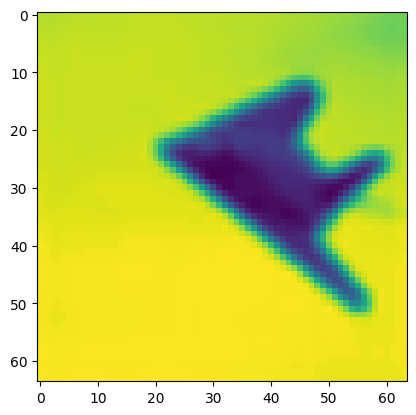

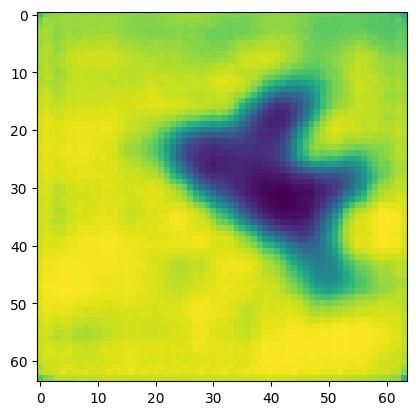

In [6]:
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
with torch.no_grad():
    im = data[0]
    latent_rep = encoder(im)
    output = decoder(latent_rep)
print(np.array(im.to('cpu')[0]).shape)
plt.imshow(np.array(im.to('cpu')[0]))
plt.show()
plt.imshow(np.array(output.to('cpu')[0]))
plt.show()

In [48]:
def get_model_size(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    
    buffer_size = 0
    for buffer in model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()
    
    size_in_bytes = param_size + buffer_size
    size_in_megabytes = size_in_bytes / (1024 ** 2)
    
    return size_in_megabytes

In [49]:
encoder_size = get_model_size(encoder)
decoder_size = get_model_size(decoder)

print(f"Encoder model size: {encoder_size:.2f} MB")
print(f"Decoder model size: {decoder_size:.2f} MB")

Encoder model size: 42.52 MB
Decoder model size: 42.52 MB


In [66]:
from skimage.metrics import structural_similarity as ssim
def calculate_ssim(im1, im2):

    # Calculate SSIM for each channel and take the mean
    ssim_value = np.mean([
        ssim(im1[:, :], im2[:, :], data_range=im2[:, :].max() - im2[:, :].min())
    ])
    
    return ssim_value

In [67]:
im1 = np.array(im.to('cpu')[0])
im2 = np.array(output.to('cpu')[0])

ssim_value = calculate_ssim(im1, im2)
print(f'SSIM: {ssim_value}')

SSIM: 0.6425471781270178


In [40]:
def myAtoi(s: str) -> int:
    first_condition = True
    second_condition = True
    third_condition = True
    normalization = 1
    while first_condition:
        char = s[0]
        if char == " ":
            s = s[1:]
        else:
            first_condition = False
            break
    
    while second_condition:
        char = s[0]
        if char == '-':
            normalization = -1
            s = s[1:]
        elif char == '+':
            s = s[1:]
        else:
            second_condition = False
    strin = ''
    while third_condition:
        if s:
            char = s[0]
        else:
            break
        if char in ['1','2','3','4','5','6','7','8','9']:
            strin += char
            if len(s) > 0:
                s = s[1:]
            else:
                break
        elif char == '0':
            s = s[1:]
            pass
        else:
            third_condition = False
    return normalization * int(strin)

In [42]:
myAtoi('1337c0d3')

ValueError: invalid literal for int() with base 10: 'c'